# Data Loader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import SVHN

In [2]:
svhn_train = SVHN(root='./data', split='train', download=True)

transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

# Step 3: Calculate mean and std across all pixel values
def calculate_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_samples = len(dataset)

    for i in range(num_samples):
        image, _ = dataset[i]
        mean += torch.mean(transform_to_tensor(image), dim=(1, 2))
        std += torch.std(transform_to_tensor(image), dim=(1, 2))

    mean /= num_samples
    std /= num_samples

    return mean, std

mean, std = calculate_mean_std(svhn_train)
print("Mean:", mean)
print("Std:", std)

100%|██████████| 182040794/182040794 [00:03<00:00, 52708485.13it/s]


Mean: tensor([0.4377, 0.4438, 0.4728])
Std: tensor([0.1201, 0.1231, 0.1052])


In [3]:
batch_size=16

# Define transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Download and load the training dataset
trainset = SVHN(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download and load the test dataset
testset = SVHN(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in SVHN dataset
classes = list(range(10))

Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [00:01<00:00, 35257285.93it/s]


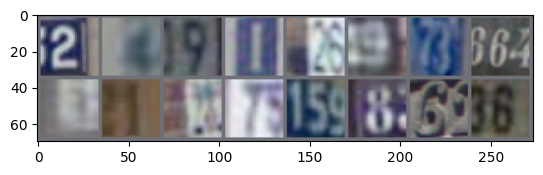

    2     4     9     1     2     9     3     6     3     1     2     7     5     8     6     6


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Unnormalize the images
    img = img * std[:, None, None] + mean[:, None, None]

    # Convert torch tensor to numpy array
    npimg = img.numpy()

    # Transpose the image array to match matplotlib format
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Assuming `images` is a torch tensor of shape (batch_size, channels, height, width)
# Assuming `trainloader` is your DataLoader object
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Model

In [5]:
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.init as init

## VAE

In [6]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        
        #Weight initialization
        init.xavier_normal_(self.conv.weight)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

In [7]:
class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
        # Weight initialization
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [8]:
class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )
            
        # Weight initialization
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [9]:
class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        
        #self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)
        
        # Weight initialization
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.xavier_normal_(self.linear.weight)
        

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

In [10]:
class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        #self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=1)
        

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)       #reshaped to have dimensions (batch_size, 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        
        #x = x.view(x.size(0), 3, 64, 64)
        x = x.view(x.size(0), 3, 32, 32)

        return x

In [11]:
class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def forward(self, x):
        mean, logvar = self.encoder(x)
        #z = self.reparameterize(mean, logvar)

        # sample z from q
        std = torch.exp(logvar / 2)
        q = torch.distributions.Normal(mean, std)
        z = q.rsample()
        
        x_recon = self.decoder(z)   
        
        return x_recon, mean, logvar, z
    
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss(self, x_hat, x, z, mu, logvar):
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        std = torch.exp(logvar / 2)
        kl = self.kl_divergence(z, mu, std)

        # elbo
        #print(kl,recon_loss)
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        return elbo
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

### Test

In [12]:
# Get a batch of images and labels
dataiter = iter(trainloader)
images, _ = next(dataiter)

# Forward pass through VAE model to obtain reconstructed images, mean, and log variance
vae_model_ins = VAE(z_dim=128)
recon_images, mu, logvar, z = vae_model_ins(images)

# Compute VAE loss
loss = vae_model_ins.loss(recon_images, images, z, mu, logvar)
# Print the loss

print("VAE Loss:", loss.item())

VAE Loss: 7284.72412109375


## Block 2

In [13]:
class LatentMapper(nn.Module):
    def __init__(self, y_dim, z_dim, hidden_dims):
        super(LatentMapper, self).__init__()
        layers = []
        input_dim = y_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, z_dim))
        self.fc_layers = nn.Sequential(*layers)
        self.z_dim = z_dim
        
    def forward(self, y):
        z = self.fc_layers(y)
        return z
    
    #def loss():
        #Contrastive Loss


In [14]:
lm_ins = LatentMapper(y_dim=128, z_dim=16, hidden_dims=[64, 32])
lm_ins

LatentMapper(
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
)

## NET

In [15]:
class NET(nn.Module):
    def __init__(self, vae, latent_mapper):
        super(NET, self).__init__()
        self.vae = vae
        self.latent_mapper = latent_mapper
        self.classifier = nn.Linear(self.latent_mapper.z_dim, 10)  # 10 is the number of classes
        
    def forward(self, x):
#         mu, logvar = self.vae.encode(x)
#         y = self.vae.reparameterize(mu, logvar)
        x_hat, mu, logvar, y = self.vae(x)
        z = self.latent_mapper(y)
        logits  = self.classifier(z)
        return x_hat, mu, logvar, y, logits 
    
    def loss(self, x_hat, x, y, mu, logvar, logits, labels, alpha=1, beta=1, gamma=1):
        vae_loss = self.vae.loss(x_hat, x, y, mu, logvar)
        classification_loss = nn.CrossEntropyLoss()(logits, labels)
        #print(vae_loss , classification_loss)
        return  alpha * vae_loss + beta * classification_loss # + gamma * contrastive_loss

### Test

In [16]:
# Get a batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

net_ins = NET(vae_model_ins, lm_ins)
recon_images, mu, logvar, y, logits = net_ins(images)

loss = net_ins.loss(recon_images, images, y, mu, logvar, logits, labels)
# Print the loss
print("Loss:", loss.item())

Loss: 7006.15966796875


# Training

In [17]:
from tqdm.auto import tqdm

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
from torch.optim import Adam,SGD
from torch.optim.lr_scheduler import StepLR,ExponentialLR

### VAE Training

In [20]:
# vae_model = VAE(z_dim=128)
# vae_model.to(device)

# optimizer = Adam(vae_model.parameters())
# scheduler = ExponentialLR(optimizer, gamma=0.99)

In [21]:
# EPOCHS=1
# loss_values=[np.nan]

# for epoch in range(EPOCHS): 
#     vae_model.train()
#     running_loss = 0.0
#     epoch_loss=0.0
#     for i, data in tqdm(enumerate(trainloader, 0), desc="Training Progress"):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         x_hat, mu, logvar,z = vae_model(inputs)
#         loss = vae_model.loss(x_hat, inputs, z, mu, logvar)
#         loss.backward()
#         optimizer.step()
        

#         # print statistics
#         running_loss += loss.item() 
#         epoch_loss += loss.item() 

#         if i % 1000 == 999:    # print every 1000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.1f}')
#             running_loss = 0.0
#     epoch_loss /= len(trainloader) * batch_size
#     loss_values.append(epoch_loss) 
#     print(f'Epoch {epoch + 1} loss: {epoch_loss:.3f}')
#     scheduler.step()
    
# print()
# print('Training Finished... ')

In [22]:
# PATH = './VAE_net.pth'
# torch.save(vae_model.state_dict(), PATH)

In [23]:
# vae_model1 = VAE(z_dim=128)
# vae_model1.load_state_dict(torch.load(PATH))

In [24]:
# dataiter = iter(testloader)
# images, labels = next(dataiter)

# # print images
# imshow(torchvision.utils.make_grid(images))
# #print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [25]:
# outputs, _, _, _ = vae_model1(images)
# imshow(torchvision.utils.make_grid(outputs))

In [26]:
# loss_values

In [27]:
# plt.figure(figsize=(16,6))
# plt.plot(loss_values,color='red')
# plt.xticks(np.arange(0, EPOCHS+1, step=1))
# plt.grid()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Epoch loss values during training')
# plt.savefig('./VAE_losses_plot.png');

### NET training

In [28]:
vae = VAE(z_dim=128)
latent_mapper = LatentMapper(y_dim=128, z_dim=16, hidden_dims=[64, 32])
net = NET(vae, latent_mapper)

vae.to(device)
latent_mapper.to(device)
net.to(device);

optimizer = Adam(net.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.99)

In [29]:
EPOCHS=1
loss_values=[np.nan]

for epoch in range(EPOCHS): 
    net.train()
    running_loss = 0.0
    epoch_loss=0.0
    for i, data in tqdm(enumerate(trainloader, 0), desc="Training Progress"):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        recon_images, mu, logvar, y, logits = net(inputs)
        loss = net.loss(recon_images, inputs, y, mu, logvar, logits, labels, beta=100)
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item() 
        epoch_loss += loss.item() 

        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] running loss: {running_loss / 1000:.1f}')
            running_loss = 0.0
    epoch_loss /= len(trainloader) * batch_size
    loss_values.append(epoch_loss) 
    print(f'Epoch {epoch + 1} loss: {epoch_loss:.3f}')
    scheduler.step()
    
print()
print('Training Finished... ')

Training Progress: 0it [00:00, ?it/s]

[1,  1000] running loss: 6270.5
[1,  2000] running loss: 5859.7
[1,  3000] running loss: 5828.2
[1,  4000] running loss: 5808.2
Epoch 1 loss: 369.987

Training Finished... 


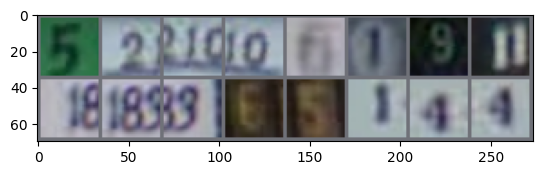

In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [31]:
net.eval()
images = images.to(device)
labels = labels.to(device)

_, _, _, _, logits = net(images)
_, predicted = torch.max(logits, 1)
print('Preds:\n',predicted)
print('GTs:\n',labels)


Preds:
 tensor([6, 2, 1, 6, 6, 1, 6, 1, 1, 6, 2, 6, 2, 1, 4, 1], device='cuda:0')
GTs:
 tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4], device='cuda:0')


In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        _, _, _, _, logits = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)} test images: {100 * correct // total} %')

Accuracy of the network on the 1627 test images: 32 %


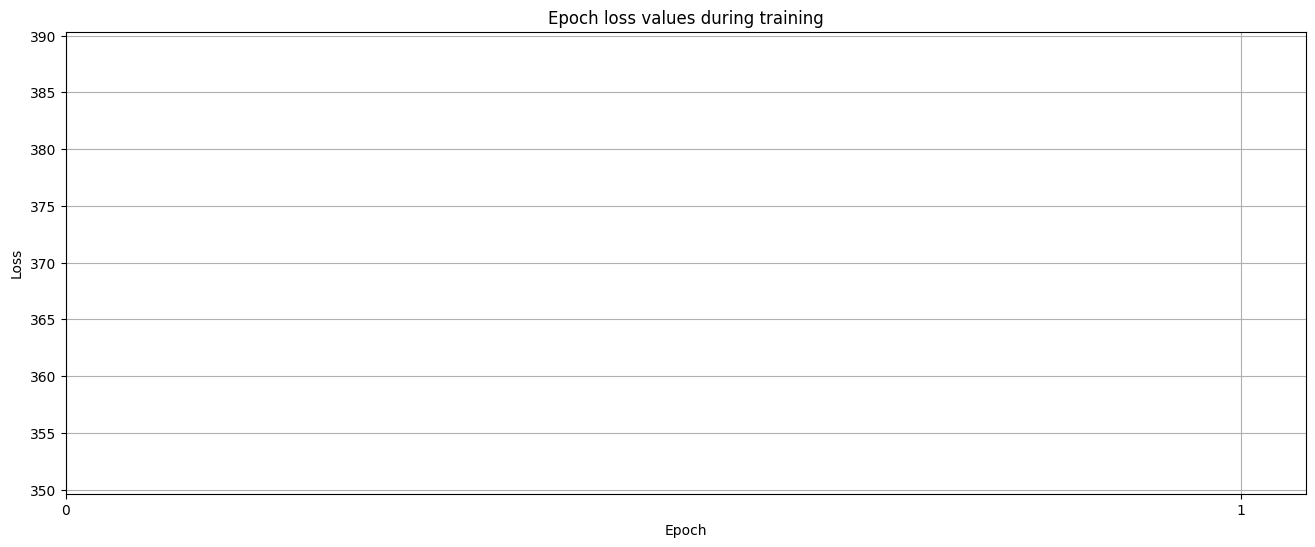

In [33]:
plt.figure(figsize=(16,6))
plt.plot(loss_values,color='red')
plt.xticks(np.arange(0, EPOCHS+1, step=1))
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch loss values during training')
plt.savefig('./Classification_losses_plot.png');